**Importing Necessary Libraries and Packages**

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

**Reading the Dataset .csv File**

In [2]:
chat = pd.read_csv('chat.csv')
chat

,Message,sentiment
0,Don't piss in my garden and tell me you're try...,negative
1,The owner complained Digger had no energy and ...,negative
2,"You and the babe are no innocents, and you wel...",negative
3,I have no sympathy for whatever cause they thi...,negative
4,"If Yorkshire can't give it to them, they will ...",negative
...,...,...
5022,Your impolite behavior will cause you and the ...,negative
5023,He is really impolite to his elders.,negative
5024,Don't act so impolitely!,negative
5025,He wasn't just impolite he was downright rude.,negative


In [3]:
# Shuffling the Rows of the Dataset DataFrame
from sklearn.utils import shuffle
chat = shuffle(chat)
chat.reset_index(inplace=True, drop=True)
chat

,Message,sentiment
0,hahaha,positive
1,Your statement is false.,negative
2,This must be South Africa ... doubt its st Law...,positive
3,He has always been considered undesirable.,negative
4,Talk on it Michael,positive
...,...,...
5022,Was he regretting their marriage?,negative
5023,Happy birthday Uncle John!!!!,positive
5024,What a letdown to have this pervert with us!,negative
5025,What am I supposed to do if I'm undesired by m...,negative


In [4]:
chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5027 entries, 0 to 5026
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Message    5027 non-null   object
 1   sentiment  5027 non-null   object
dtypes: object(2)
memory usage: 78.7+ KB


**Defining Function for Sequencing and Padding**

In [5]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=30, padding='post', truncating='post')
    
    return sequences

In [6]:
# Defining Function for Assigning 1 and 0 to Sentiments
def sentiment_encoder(sentiment):
  if sentiment == 'negative':
    return 1
  else:
    return 0

In [7]:
# Creating Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="<OOV>")

**Defining Function to Generate Sequences After Making Train and Test Datasets**

In [8]:
def message_encoder(df):
    df = df.copy()
    
    # Split df into X and Y
    X = df['Message']
    Y = df['sentiment']
    Y = Y.apply(sentiment_encoder)

    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=42)
    
    # Fitting the Tokenizer
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    
    # Converting Texts to Sequences
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])

    return X_train, X_test, Y_train, Y_test

In [9]:
X_train, X_test, Y_train, Y_test = message_encoder(chat)

In [10]:
X_train

array([[  42,  730,   24, ...,    0,    0,    0],
       [  23,   30, 3557, ...,    0,    0,    0],
       [3558,   16,  287, ...,   17, 2369, 1464],
       ...,
       [  87,  385,    0, ...,    0,    0,    0],
       [1089,  342, 1014, ...,    0,    0,    0],
       [  23,   30, 3474, ...,    0,    0,    0]], dtype=int32)

In [11]:
X_train.shape, X_test.shape

((3518, 30), (1509, 30))

In [12]:
Y_train.value_counts()

1    1765
0    1753
Name: sentiment, dtype: int64

**Building the Deep Neural Network Model**

In [13]:
inputs = tf.keras.Input(shape=(30,))

embedding = tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 64)            640000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 641,921
Trainable params: 641,921
Non-trainable params: 0
_________________________________________________________________
None


**Training the Model**

In [14]:
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
44/44 [==============================] - 2s 16ms/step - loss: 0.6509 - accuracy: 0.7178 - auc: 0.8032 - val_loss: 0.5902 - val_accuracy: 0.7713 - val_auc: 0.8797
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.4980 - accuracy: 0.7996 - auc: 0.8912 - val_loss: 0.4452 - val_accuracy: 0.8054 - val_auc: 0.9186
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 0.3543 - accuracy: 0.8621 - auc: 0.9488 - val_loss: 0.3485 - val_accuracy: 0.8480 - val_auc: 0.9529
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 0.2500 - accuracy: 0.9335 - auc: 0.9801 - val_loss: 0.2943 - val_accuracy: 0.8707 - val_auc: 0.9684
Epoch 5/50
44/44 [==============================] - 0s 9ms/step - loss: 0.1823 - accuracy: 0.9584 - auc: 0.9897 - val_loss: 0.2575 - val_accuracy: 0.8991 - val_auc: 0.9730
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1364 - accuracy: 0.9705 - auc: 0.9944 - val_loss: 0.2353 - val_

**Evaluating Loss and Accuracy of the Model on Test Dataset**

In [15]:
results = model.evaluate(X_test, Y_test, verbose=0)

print("    Test Loss: {:.4f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

    Test Loss: 0.2053
Test Accuracy: 91.32%
     Test AUC: 0.9754


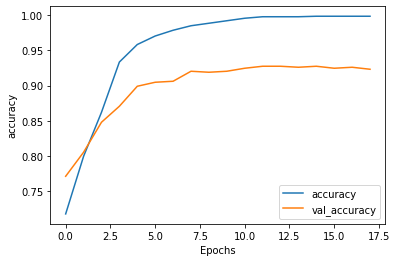

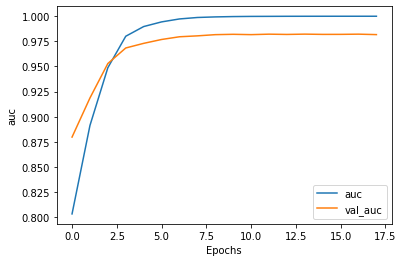

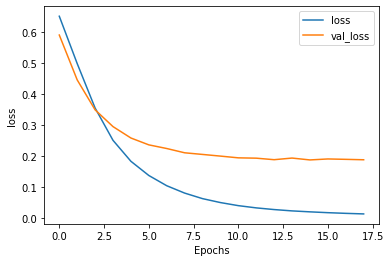

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
print('\n')
plot_graphs(history, "auc")
print('\n')
plot_graphs(history, "loss")

**Testing the Model on Sample Sentences**

In [17]:
user_text = ["I’m so happy for you.", "The weather is really nice today!", "Don't blame her.", "Don't take us to a lame place."]

tokenizer.fit_on_texts(user_text)
seq = tokenizer.texts_to_sequences(user_text)
pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=30, padding='post', truncating='post')

prediction = model.predict(pad)

user_df = pd.DataFrame(user_text, columns = ['Message'])
user_df['Sentiment_Score'] = pd.DataFrame(prediction)
user_df.loc[(user_df['Sentiment_Score'] > 0.5), 'Sentiment'] = 'negative'
user_df = user_df.fillna('positive')
print(user_df)

                             Message  Sentiment_Score Sentiment
0              I’m so happy for you.         0.111365  positive
1  The weather is really nice today!         0.288861  positive
2                   Don't blame her.         0.944517  negative
3     Don't take us to a lame place.         0.979469  negative


**Preprocessing the User Input WhatsApp .txt File**

In [18]:
def date_time(s):
    pattern='^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result=re.match(pattern, s)
    if result:
        return True
    return False 

def find_contact(s):
    s=s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getMessage(line):
    splitline=line.split(' - ')
    datetime= splitline[0];
    date, time= datetime.split(', ')
    message=" ".join(splitline[1:])
    
    if find_contact(message):
        splitmessage=message.split(": ")
        author=splitmessage[0]
        message=splitmessage[1]
    else:
        author=None
    return date, time, author, message

user_input=[]
chat = 'User Input Chat.txt'
with open(chat, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer=[]
    date, time, author = None, None, None
    while True:
        line=fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer)>0:
                user_input.append([date, time, author, ''.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getMessage(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

df=pd.DataFrame(user_input, columns=["Date", "Time", "Contact", "Message"])
df['Date']=pd.to_datetime(df['Date'])

user_input = df.dropna()
user_input = user_input.drop(["Date", "Time", "Contact"], axis = 1)
user_input.reset_index(inplace=True, drop=True)
user_input

,Message
0,Let’s hang out somewhere this weekend.
1,"Yeah, good idea!"
2,I’m all in for it.
3,Me too! I’m really excited.
4,Where are we going?
5,Don’t take us to a lame place.
6,How about we go to the cafe by the station?
7,"No, that cafe is really expensive."
8,I hate the food there.
9,We can trust him when it comes to food.


**Using the Model to Predict the Sentiments for User Input Messages**

In [19]:
user_message = user_input.Message

sequences = tokenizer.texts_to_sequences(user_message)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=30, padding='post', truncating='post')

prediction = model.predict(padded)

user_input['Sentiment_Score'] = pd.DataFrame(prediction)
user_input.loc[(user_input['Sentiment_Score'] > 0.5), 'Sentiment'] = 'negative'
user_input = user_input.fillna('positive')

In [20]:
user_input

,Message,Sentiment_Score,Sentiment
0,Let’s hang out somewhere this weekend.,0.103006,positive
1,"Yeah, good idea!",0.031147,positive
2,I’m all in for it.,0.325122,positive
3,Me too! I’m really excited.,0.039120,positive
4,Where are we going?,0.140247,positive
5,Don’t take us to a lame place.,0.849130,negative
6,How about we go to the cafe by the station?,0.140827,positive
7,"No, that cafe is really expensive.",0.473656,positive
8,I hate the food there.,0.969263,negative
9,We can trust him when it comes to food.,0.963171,negative
